#follow this to install prismnet
https://github.com/kuixu/PrismNet

In [1]:
import argparse, os, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler



from sklearn import metrics
import numpy as np

import prismnet.model as arch
from prismnet import train, validate, inference, log_print, compute_saliency, compute_saliency_img, compute_high_attention_region
#compute_high_attention_region

# from prismnet.engine.train_loop import 
from prismnet.model.utils import GradualWarmupScheduler
from prismnet.loader import SeqicSHAPE
from prismnet.utils import datautils

In [2]:
# # out dir

# identity   = args.p_name+'_'+args.arch+"_"+args.mode # 441_PUM2_K562_sub4509_PrismNet_pu.metrics
# datautils.make_directory(args.out_dir,"out/")
# model_dir  = datautils.make_directory(args.out_dir,"out/models")
# model_path = os.path.join(model_dir, identity+"_{}.pth")

# if args.tfboard:
#     tfb_dir  = datautils.make_directory(args.out_dir,"out/tfb")
#     writer = SummaryWriter(tfb_dir)
# else:
#     writer = None
# # fix random seed
# fix_seed(args.seed)

In [3]:
import pandas as pd
outstem = 'K562_rep6'

megaoutput = pd.read_csv(f'../data/ABC_data/{outstem}.megaoutputs_masked.tsv', sep = '\t')
seq = pd.read_csv(f'../data/ABC_data/tsv/{outstem}.DDX3.tsv', sep = '\t', names = ['chrom', 'name', 
                                                                          'seq', 'struct', 'label', 'start'])
outstem2= outstem+ '.region_type'

In [4]:
max_length=seq['seq'].str.len().max()

In [5]:
from prismnet.utils import datautils

In [6]:
one_hot = datautils.convert_one_hot(seq['seq'], max_length)

In [7]:
one_hot.shape # N, 4, max_length

(138498, 4, 100)

In [8]:
data = one_hot

In [9]:
# prepare region
def make_binary(df, col):
    binary_df = pd.DataFrame(False, index = df.index, columns = df[col[:-1]+'_top'].unique())
    for index, row in df.iterrows():
        binary_df.loc[index, row[col].split(':')] = True
    
    return binary_df
    

feature_binary = make_binary(megaoutput, 'feature_types')

In [10]:
# targets: predict binary
target_col = megaoutput.columns[(megaoutput.columns.str.startswith('logLR'))&(megaoutput.columns.str.contains(outstem))]
target_df = megaoutput[target_col]

<AxesSubplot:>

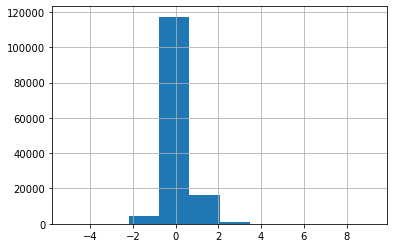

In [11]:
target_df[f'logLR:{outstem}.PUM2'].hist()

In [12]:
targets = target_df.values
targets.shape

(138498, 10)

In [13]:
def split_dataset(data, feature_binary, targets, valid_frac=0.2):
    
    ind0 = np.where(targets<0.5)[0]
    ind1 = np.where(targets>=0.5)[0]
    
    n_neg = int(len(ind0)*valid_frac)
    n_pos = int(len(ind1)*valid_frac)

    shuf_neg = np.random.permutation(len(ind0))
    shuf_pos = np.random.permutation(len(ind1))

    X_train = np.concatenate((data[ind1[shuf_pos[n_pos:]]], 
                              data[ind0[shuf_neg[n_neg:]]]))
    X_train_feature = np.concatenate((feature_binary[ind1[shuf_pos[n_pos:]]], 
                              feature_binary[ind0[shuf_neg[n_neg:]]]))
    Y_train = np.concatenate((targets[ind1[shuf_pos[n_pos:]]], 
                              targets[ind0[shuf_neg[n_neg:]]]))
    train = (X_train, X_train_feature, Y_train)

    X_test = np.concatenate((data[ind1[shuf_pos[:n_pos]]], 
                             data[ind0[shuf_neg[:n_neg]]]))
    X_test_feature = np.concatenate((feature_binary[ind1[shuf_pos[:n_pos]]], 
                             feature_binary[ind0[shuf_neg[:n_neg]]]))
    Y_test = np.concatenate((targets[ind1[shuf_pos[:n_pos]]], 
                             targets[ind0[shuf_neg[:n_neg]]]))
    test = (X_test, X_test_feature, Y_test)

    return train, test

In [14]:
train, test = split_dataset(data, feature_binary.values, targets, valid_frac=0.2)

target_data_type = np.float32

In [15]:
train[0].shape, train[1].shape, test[0].shape, test[1].shape

((1107985, 4, 100), (1107985, 18), (276995, 4, 100), (276995, 18))

In [16]:
from prismnet.model.PrismNet import *
class PrismNet_Multitask_feature(nn.Module):
    def __init__(self, mode="pu", output_dim=10, n_feature = 18):
        super(PrismNet_Multitask_feature, self).__init__()
        self.mode = mode
        h_p, h_k = 2, 5 
        if mode=="pu":
            self.n_features = 5
        elif mode=="seq":
            self.n_features = 4
            h_p, h_k = 1, 3 
        elif mode=="str":
            self.n_features = 1
            h_p, h_k = 0, 1
        else:
            raise "mode error"
        
        base_channel = 8
        self.conv    = Conv2d(1, base_channel, kernel_size=(11, h_k), bn = True, same_padding=True)
        self.se      = SEBlock(base_channel)
        self.res2d   = ResidualBlock2D(base_channel, kernel_size=(11, h_k), padding=(5, h_p)) 
        self.res1d   = ResidualBlock1D(base_channel*4) 
        self.avgpool = nn.AvgPool2d((1,self.n_features))
        self.gpool   = nn.AdaptiveAvgPool1d(1)
        self.fc      = nn.Linear(base_channel*4*8, output_dim)
        
        
        # take into feature
        self.feature_fc = nn.Linear(n_feature, output_dim)
        
        # total score
        self.total_fc = nn.Linear(output_dim*2, output_dim)
        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, input, feat_input):
        """[forward]
        
        Args:
            input ([tensor],N,C,W,H): input features
            feat_input([tensor], N, n_feature): region types, 3UTR etc
        """
        # sequence score
        if self.mode=="seq":
            input = input[:,:,:,:4]
        elif self.mode=="str":
            input = input[:,:,:,4:]
        x = self.conv(input)
        x = F.dropout(x, 0.1, training=self.training)
        z = self.se(x)
        x = self.res2d(x*z)
        x = F.dropout(x, 0.5, training=self.training)
        x = self.avgpool(x)
        x = x.view(x.shape[0], x.shape[1], x.shape[2])
        x = self.res1d(x)
        x = F.dropout(x, 0.3, training=self.training)
        x = self.gpool(x)
        x = x.view(x.shape[0], x.shape[1])
        x = self.fc(x) # 1107985, 10
        
        
        # feature score
        x_feat = self.feature_fc(feat_input) #1107985, 18 => 1107985, 10
        
        
        
        # total
        x_total = self.total_fc(torch.cat([x, x_feat], dim=1))
        return x

In [17]:
model = PrismNet_Multitask_feature(mode = 'seq', output_dim = targets.shape[1], n_feature = train[1].shape[1])

In [18]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [19]:
model = model.to(device)

In [20]:
class SeqicSHAPE_Multitask_feature(torch.utils.data.Dataset):
    def __init__(self, X, X_feature, Y, is_infer=False, use_structure=True):
        """data loader
        
        Args:
            data_path ([str]): h5 file path
            is_test (bool, optional): testset or not. Defaults to False.
        """
        if is_infer:
            self.dataset = self.__load_infer_data__(data_path, use_structure=use_structure)
            print("infer data: ", self.__len__()," use_structure: ", use_structure)
        else:
#             dataset = h5py.File(data_path, 'r')
#             X_train = np.array(dataset['X_train']).astype(np.float32)
#             Y_train = np.array(dataset['Y_train']).astype(np.int32)
#             X_test  = np.array(dataset['X_test']).astype(np.float32)
#             Y_test  = np.array(dataset['Y_test']).astype(np.int32)
            X = np.array(X).astype(np.float32)
            X_feature = np.array(X_feature).astype(np.float32)
            Y = np.array(Y).astype(np.float32)
#             if len(Y_train.shape) == 1:
#                 Y_train = np.expand_dims(Y_train, axis=1)
#                 Y_test  = np.expand_dims(Y_test, axis=1)
            X = np.expand_dims(X, axis=3).transpose([0, 3, 2, 1]) # N, 1, length, channel
            

            

#             labels, nums = np.unique(Y_train,return_counts=True)
#             print("train:", labels, nums)
#             labels, nums = np.unique(Y_test,return_counts=True)
#             print("test:", labels, nums)

#             train = self.__prepare_data__(train)
#             test  = self.__prepare_data__(test)

            
            self.dataset = {'inputs': X, 'inputs_feat': X_feature, 'targets': Y}
            

        

    def __load_infer_data__(self, data_path, use_structure=True):
        from prismnet.utils import datautils
        dataset = datautils.load_testset_txt(data_path, use_structure=use_structure, seq_length=101)
        return dataset
       
    
    def __prepare_data__(self, data):
        inputs    = data['inputs'][:,:,:,:4]
        structure = data['inputs'][:,:,:,4:]
        structure = np.expand_dims(structure[:,:,:,0], axis=3)
        inputs    = np.concatenate([inputs, structure], axis=3)
        data['inputs']  = inputs
        return data

    def __to_sequence__(self, x):
        x1 = np.zeros_like(x[0,:,:1])
        for i in range(x1.shape[0]):
            # import pdb; pdb.set_trace()
            x1[i] = np.argmax(x[0,i,:4])
            # import pdb; pdb.set_trace()
        return x1

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        x = self.dataset['inputs'][index]
        x_feat = self.dataset['inputs_feat'][index]
        # x = self.__to_sequence__(x)
        y = self.dataset['targets'][index]
        return x, x_feat, y


    def __len__(self):
        return len(self.dataset['inputs'])



In [21]:
train[0][:300].shape

(300, 4, 100)

In [22]:
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    
    
    SeqicSHAPE_Multitask_feature(train[0], train[1], train[2], is_infer=False, use_structure=False), 
batch_size=64, shuffle=True,  **kwargs)

test_loader  = torch.utils.data.DataLoader(
    SeqicSHAPE_Multitask_feature(test[0], test[1], test[2], is_infer=False, use_structure=False),
batch_size=64*8, shuffle=False, **kwargs)

print("Train set:", len(train_loader.dataset)) #X_train (example=91099, ATCGshape=5, length=101)
#X_train (example=91099, ATCGshape=5, length=101)
#Y_train (example=91099, binary_outcome=1))
print("Test  set:", len(test_loader.dataset))

Train set: 1107985
Test  set: 276995


In [31]:
def train(model, device, train_loader, criterion, optimizer):
    ''' train for one epoch'''
    model.train()
    epoch_loss = 0
    for batch_idx, (x0, x_feat0, y0) in enumerate(train_loader):
        x, x_feat, y = x0.float().to(device), x_feat0.to(device).float(), y0.to(device).float()
        
        optimizer.zero_grad()
        output = model(x, x_feat)
        
        loss = criterion(output, y)
        epoch_loss+=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

    return epoch_loss
def validate(model, device, test_loader, criterion):
    model.eval()
    y_all = []
    p_all = []
    l_all = []
    epoch_loss = 0
    with torch.no_grad():
        for batch_idx, (x0, x_feat0, y0) in enumerate(test_loader):
            x, x_feat, y = x0.float().to(device), x_feat0.to(device).float(), y0.to(device).float()
            
            
            output  = model(x, x_feat)
            loss = criterion(output, y)
            
            epoch_loss += loss.item()
            y_np = output.to(device='cpu', dtype=torch.float32).numpy()
            y_all.append(y_np)
            

    return epoch_loss, y_all

In [24]:
try:
    metric=pd.read_csv(f'../data/ABC_data/{outstem2}.training_curve.csv')
except:
    pass

In [25]:
# #from prismnet.utils import metrics
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-6)
# nepoch = 60
# scheduler = GradualWarmupScheduler(
#     optimizer, multiplier=8, total_epoch=nepoch, after_scheduler=None)
# criterion = torch.nn.MSELoss()
# batch_size= 64

# best_test_loss = np.inf

# metric = []
# current_epoch = 0

# best_test_loss = np.inf
# epoch = 0
# current_epoch = epoch
# for epoch in range(current_epoch, current_epoch + nepoch + 1):
#     print(f'At epoch {epoch}')
#     train_loss = train(model, device, train_loader, criterion, optimizer)
#     metric.append(['train', epoch, train_loss])
    
#     test_loss, y_pred = validate(model, device, test_loader, criterion)
#     metric.append(['test', epoch, test_loss])

#     if test_loss < best_test_loss:
#         filename = f'../data/ABC_data/{outstem}.model.pt'
#         torch.save(model.state_dict(), filename)
#         best_test_loss = test_loss
        
#     metric_df = pd.DataFrame(metric, columns = ['type', 'epoch', 'loss'])
#     metric_df.to_csv(f'../data/ABC_data/{outstem}.training_curve.csv')
    
#     if epoch % 5 == 0:
#         metric_df.groupby(by = 'type').plot(x = 'epoch', y = 'loss', subplots = False)
    
    

In [27]:
model.load_state_dict(torch.load(f'../data/ABC_data/{outstem2}.model.pt'))

<All keys matched successfully>

In [ ]:
#metric = pd.DataFrame(metric, columns = ['type', 'epoch', 'loss'])

type
test     AxesSubplot(0.125,0.125;0.775x0.755)
train    AxesSubplot(0.125,0.125;0.775x0.755)
Name: loss, dtype: object

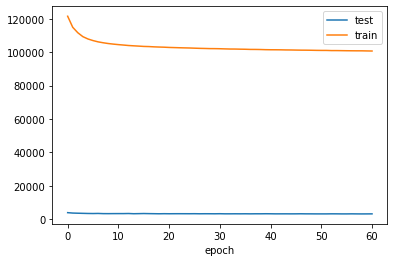

In [28]:
metric.set_index('epoch').groupby(by = 'type')['loss'].plot(legend = True)

In [ ]:
#metric.to_csv(f'../data/ABC_data/{outstem}.training_curve.csv')

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-6)
nepoch = 60
scheduler = GradualWarmupScheduler(
    optimizer, multiplier=8, total_epoch=nepoch, after_scheduler=None)
criterion = torch.nn.MSELoss()
batch_size= 64

In [32]:
loss_test, y_test_pred = validate(model, device, test_loader, criterion)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [ ]:
# filename = f'../data/ABC_data/{outstem}.model.pt'
# torch.save(model.state_dict(), filename)

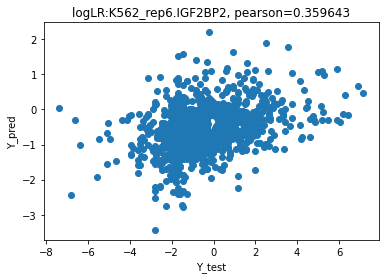

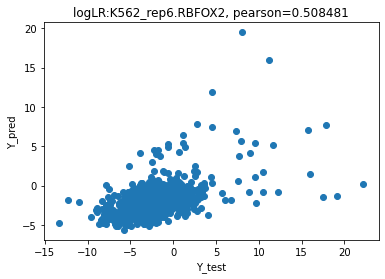

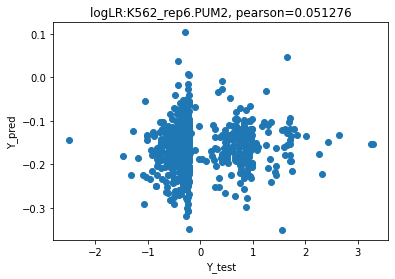

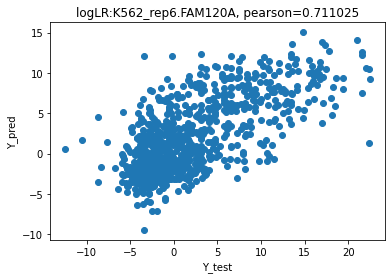

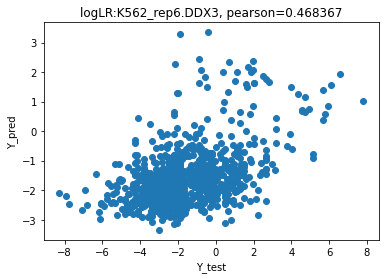

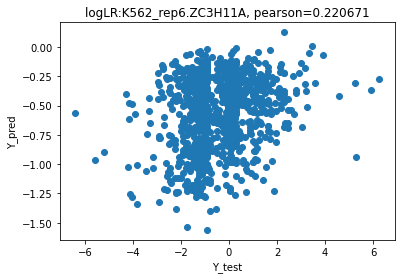

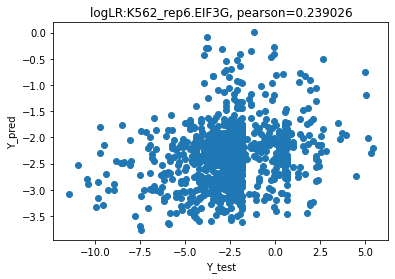

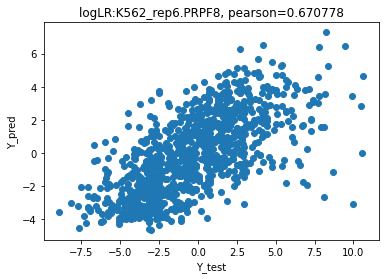

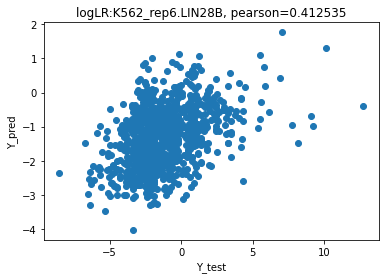

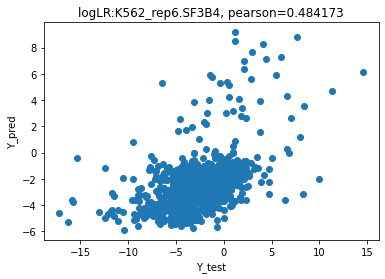

In [41]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
y_pred=np.concatenate(y_test_pred)
pearsondf = []
for rbp_idx, name in zip(range(test[2].shape[1]), target_df.columns):
    plt.scatter(test[2][:1000, rbp_idx], y_pred[:1000, rbp_idx])
    plt.xlabel('Y_test')
    plt.ylabel('Y_pred')
    r,p=pearsonr(test[2][:1000, rbp_idx],y_pred[:1000, rbp_idx])
    plt.title(f'{name}, pearson={r:2f}')
    plt.show()
    
    pearsondf.append([name, r, p])
pearsondf = pd.DataFrame(pearsondf, columns = ['RBP', 'pearsonr', 'pvalue'])

In [42]:
pearsondf

,RBP,pearsonr,pvalue
0,logLR:K562_rep6.IGF2BP2,0.359643,6.718522e-32
1,logLR:K562_rep6.RBFOX2,0.508481,7.326185e-67
2,logLR:K562_rep6.PUM2,0.051276,1.051212e-01
3,logLR:K562_rep6.FAM120A,0.711025,8.209691e-155
4,logLR:K562_rep6.DDX3,0.468367,1.150716e-55
5,logLR:K562_rep6.ZC3H11A,0.220671,1.705233e-12
6,logLR:K562_rep6.EIF3G,0.239026,1.851781e-14
7,logLR:K562_rep6.PRPF8,0.670778,1.093396e-131
8,logLR:K562_rep6.LIN28B,0.412535,2.271305e-42
9,logLR:K562_rep6.SF3B4,0.484173,6.700215e-60
